In [1]:
# 'Harcoding filter into data:'
# filt_z = copy.deepcopy(radar.fields['reflectivity'])
# filt_z['data'] = np.ma.masked_where(nukem.gate_excluded, filt_z['data'].data)
# radar.add_field('filtered_reflectvity', filt_z, replace_existing=True)

In [2]:
%matplotlib inline

import imp
import copy
import matplotlib
import matplotlib.pyplot as pl
import numpy as np
import pyart
import matplotlib.colors as colors

from copy import deepcopy
from numba import jit, int32, float32

from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain, 
                            csu_dsd, csu_kdp, csu_misc, fundamentals)


In [3]:
radar_codes = imp.load_source('radar_codes', 'radar_codes.py')

In [4]:
sound_dir = "/data/vlouf/data/soudings_netcdf/"
fd = "cfrad.20070129_205009.000_to_20070129_205810.000_CPOL_PPI_level1a.nc"
radar = pyart.io.read(fd)

In [5]:
gr = pyart.graph.RadarDisplay(radar)

# Raw data

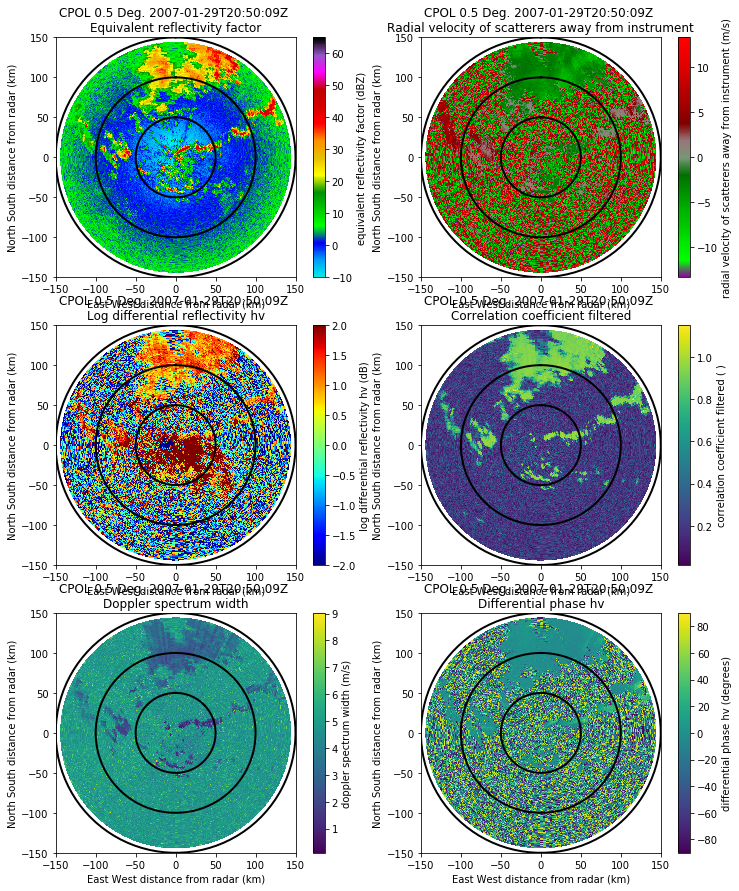

In [6]:
xy = (-150, 150, -150, 150)

fig, the_ax = pl.subplots(3, 2, figsize=(12, 15))
the_ax = the_ax.flatten()

gr.plot_ppi('DBZ', sweep=0, ax=the_ax[0])
gr.plot_ppi('VEL', sweep=0, ax=the_ax[1], cmap=pyart.graph.cm.NWSVel)
gr.plot_ppi('ZDR', sweep=0, ax=the_ax[2], vmin=-2, vmax=2, cmap='jet')
gr.plot_ppi('RHOHV', sweep=0, ax=the_ax[3])
gr.plot_ppi('WIDTH', sweep=0, ax=the_ax[4])
gr.plot_ppi('PHIDP', sweep=0, ax=the_ax[5])

for ax_sl in the_ax:
    gr.plot_range_rings([50, 100, 150], ax=ax_sl)
    ax_sl.axis('square')
    ax_sl.axis(xy)

# pl.tight_layout()
pl.show()


# Calculating SNR and correcting $\rho_{hv}$

In [7]:
z_dict, temp_dict, snr = radar_codes.snr_and_sounding(radar, sound_dir, 'DBZ')

In [8]:
radar.add_field('sounding_temperature', temp_dict, replace_existing = True)
radar.add_field('height', z_dict, replace_existing = True)
radar.add_field('SNR', snr, replace_existing = True)

In [9]:
rhohv = radar.fields['RHOHV']['data']
natural_snr = 10**(0.1*snr['data'])
rho_corr = rhohv / (1 + 1/natural_snr)
radar.add_field_like('RHOHV', 'RHOHV_CORR', rho_corr, replace_existing = True)

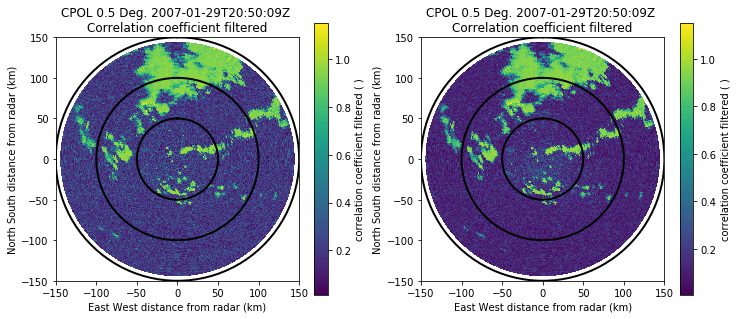

In [10]:
xy = (-150, 150, -150, 150)

fig, the_ax = pl.subplots(1, 2, figsize=(12, 5))
the_ax = the_ax.flatten()

gr.plot_ppi('RHOHV', sweep=0, ax=the_ax[0])
gr.plot_ppi('RHOHV_CORR', sweep=0, ax=the_ax[1])


for ax_sl in the_ax:
    gr.plot_range_rings([50, 100, 150], ax=ax_sl)
    ax_sl.axis('square')
    ax_sl.axis(xy)

# pl.tight_layout()
pl.show()

# Basic filter using corrected $\rho_{hv}$.

In [11]:
gf = pyart.filters.GateFilter(radar)
gf.exclude_outside('DBZ', -20, 90)
gf.exclude_below('RHOHV_CORR', 0.5)

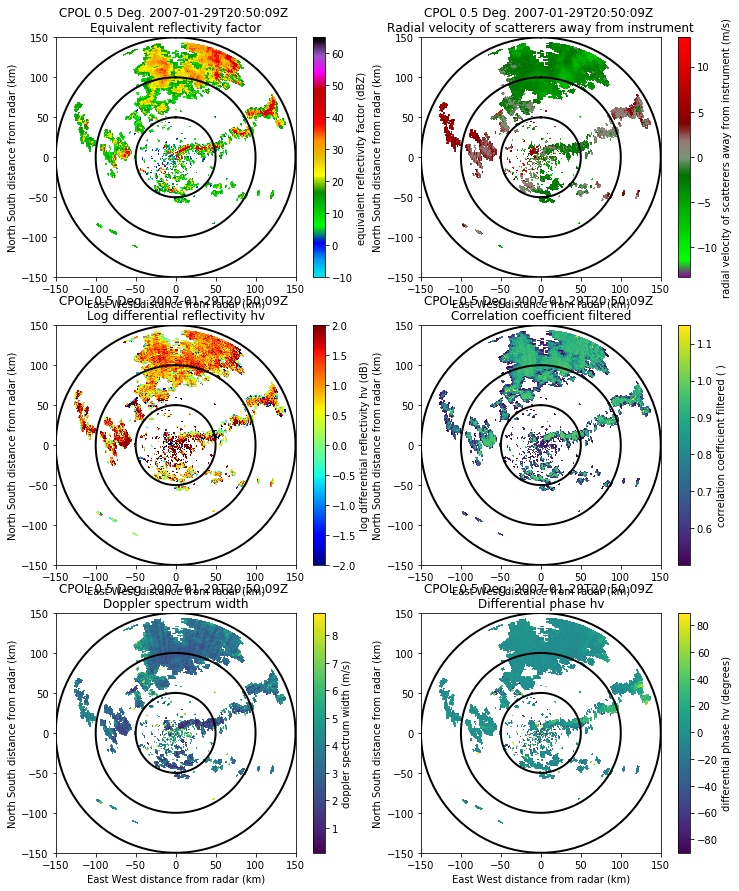

In [12]:
xy = (-150, 150, -150, 150)

fig, the_ax = pl.subplots(3, 2, figsize=(12, 15))
the_ax = the_ax.flatten()

gr.plot_ppi('DBZ', sweep=0, gatefilter=gf, ax=the_ax[0])
gr.plot_ppi('VEL', sweep=0, gatefilter=gf, ax=the_ax[1], cmap=pyart.graph.cm.NWSVel)
gr.plot_ppi('ZDR', sweep=0, gatefilter=gf, ax=the_ax[2], vmin=-2, vmax=2, cmap='jet')
gr.plot_ppi('RHOHV_CORR', sweep=0, gatefilter=gf, ax=the_ax[3])
gr.plot_ppi('WIDTH', sweep=0, gatefilter=gf, ax=the_ax[4])
gr.plot_ppi('PHIDP', sweep=0, gatefilter=gf, ax=the_ax[5])

for ax_sl in the_ax:
    gr.plot_range_rings([50, 100, 150], ax=ax_sl)
    ax_sl.axis('square')
    ax_sl.axis(xy)

# pl.tight_layout()
pl.show()


# Despeckle

In [13]:
gf_despeckeld = pyart.correct.despeckle_field(radar, 'DBZ', gatefilter=gf)

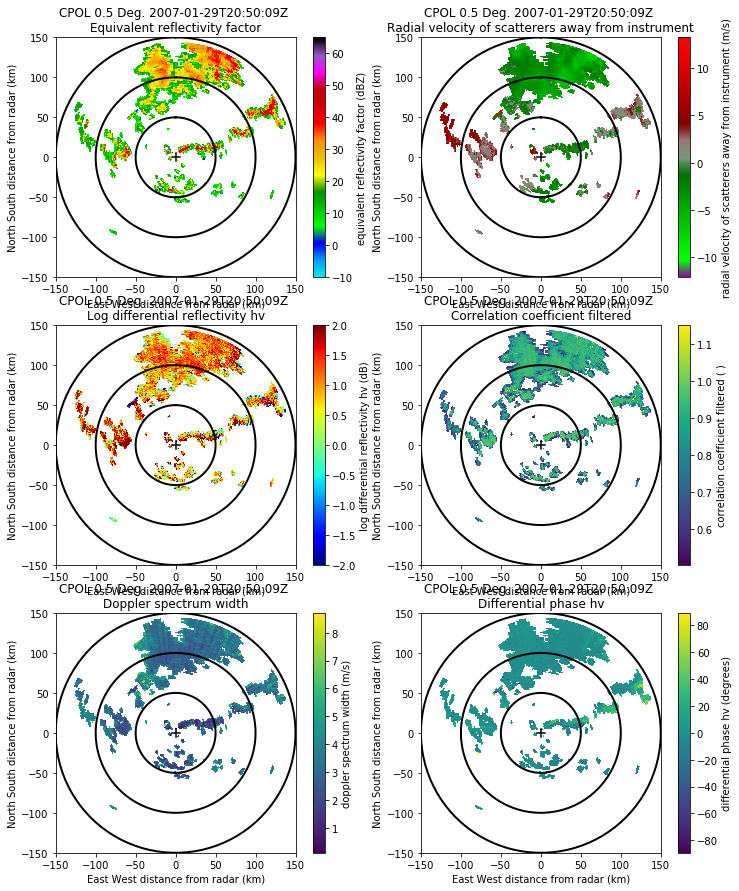

In [14]:
xy = (-150, 150, -150, 150)

fig, the_ax = pl.subplots(3, 2, figsize=(12, 15))
the_ax = the_ax.flatten()

gr.plot_ppi('DBZ', sweep=0, gatefilter=gf_despeckeld, ax=the_ax[0])
gr.plot_ppi('VEL', sweep=0, gatefilter=gf_despeckeld, ax=the_ax[1], cmap=pyart.graph.cm.NWSVel)
gr.plot_ppi('ZDR', sweep=0, gatefilter=gf_despeckeld, ax=the_ax[2], vmin=-2, vmax=2, cmap='jet')
gr.plot_ppi('RHOHV', sweep=0, gatefilter=gf_despeckeld, ax=the_ax[3])
gr.plot_ppi('WIDTH', sweep=0, gatefilter=gf_despeckeld, ax=the_ax[4])
gr.plot_ppi('PHIDP', sweep=0, gatefilter=gf_despeckeld, ax=the_ax[5])

for ax_sl in the_ax:
    gr.plot_range_rings([50, 100, 150], ax=ax_sl)
    gr.plot_cross_hair(5, ax=ax_sl)
    ax_sl.axis('square')
    ax_sl.axis(xy)

# pl.tight_layout()
pl.show()


# Correcting ZDR

In [15]:
alpha = 1.48
zdr = radar.fields['ZDR']['data']
natural_zdr = 10**(0.1*zdr)
corr_zdr = 10*np.log10((alpha*natural_snr*natural_zdr) / (alpha*natural_snr + alpha - natural_zdr))

/data/vlouf/anaconda3/envs/radar/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10


In [16]:
radar.add_field_like('ZDR', 'ZDR_CORR', corr_zdr, replace_existing=True)

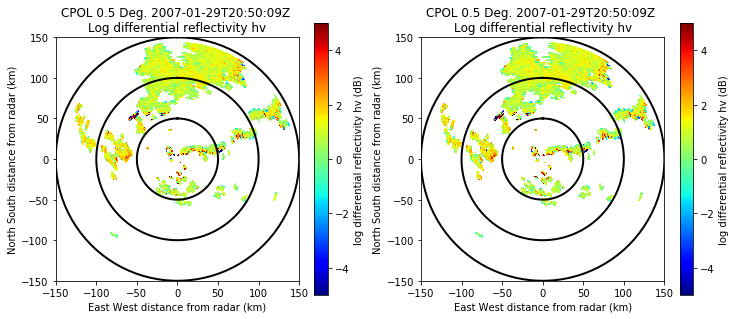

In [17]:
xy = (-150, 150, -150, 150)

fig, the_ax = pl.subplots(1, 2, figsize=(12, 5))
the_ax = the_ax.flatten()

gr.plot_ppi('ZDR', sweep=0, ax=the_ax[0], vmin=-5, vmax=5, gatefilter=gf_despeckeld, cmap='jet')
gr.plot_ppi('ZDR_CORR', sweep=0, ax=the_ax[1], vmin=-5, vmax=5, gatefilter=gf_despeckeld, cmap='jet')

for ax_sl in the_ax:
    gr.plot_range_rings([50, 100, 150], ax=ax_sl)
    ax_sl.axis('square')
    ax_sl.axis(xy)

# pl.tight_layout()
pl.show()

# Estimating KDP

In [18]:
phidp = radar.fields['PHIDP']['data'].data
phidp[gf_despeckeld.gate_excluded] = np.NaN

r = radar.range['data']
dr = (r[1] - r[0]) / 1000  # km

In [19]:
kdp_con = radar_codes.kdp_from_phidp_finitediff(phidp, dr=dr)

In [20]:
tmp = kdp_con
# tmp[tmp < 0] = np.NaN
radar.add_field_like('PHIDP', 'KDP', tmp, replace_existing=True)

# Bringi's algorithm

In [21]:
refl = radar.fields['DBZ']['data'].filled(fill_value = np.NaN)
phidp = radar.fields['PHIDP']['data'].filled(fill_value = np.NaN)

rng2d, az2d = np.meshgrid(radar.range['data'], radar.azimuth['data'])

In [22]:
kdN, fdN, sdN = csu_kdp.calc_kdp_bringi(dp=phidp, dz=refl, rng=rng2d/1000.0, thsd=6, gs=300.0, window=3, bad=np.NaN)

In [23]:
fdN = np.ma.masked_where(np.isnan(fdN), fdN)
kdN = np.ma.masked_where(np.isnan(kdN), kdN)

radar.add_field_like('PHIDP', 'PHIDP_BRINGI', fdN, replace_existing=True)
radar.add_field_like('KDP', 'KDP_BRINGI', kdN, replace_existing=True)

/data/vlouf/anaconda3/envs/radar/lib/python3.6/site-packages/matplotlib/colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


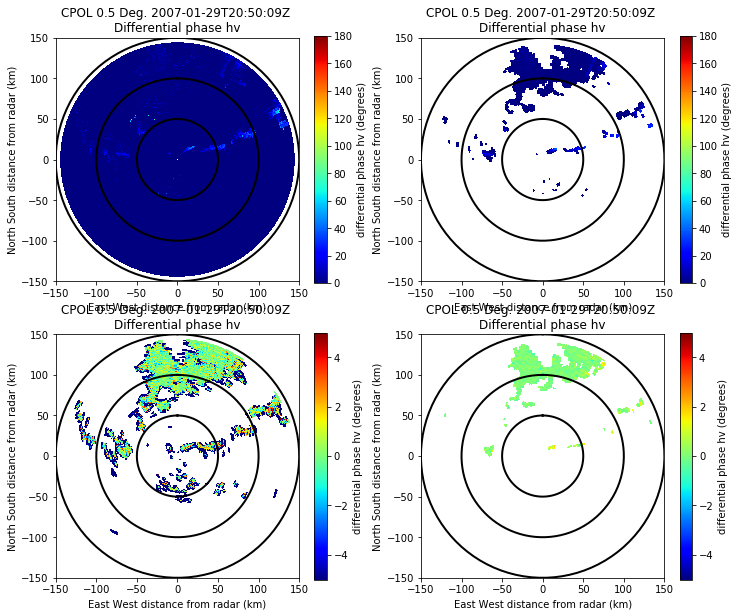

In [24]:
xy = (-150, 150, -150, 150)

fig, the_ax = pl.subplots(2, 2, figsize=(12, 10))
the_ax = the_ax.flatten()

gr.plot_ppi('PHIDP', sweep=0, ax=the_ax[0], vmin=0, vmax=180, cmap='jet')
gr.plot_ppi('PHIDP_BRINGI', sweep=0, ax=the_ax[1], vmin=0, vmax=180, cmap='jet')
gr.plot_ppi('KDP', sweep=0, ax=the_ax[2], vmin=-5, vmax=5, gatefilter=gf_despeckeld, cmap='jet')
gr.plot_ppi('KDP_BRINGI', sweep=0, ax=the_ax[3], vmin=-5, vmax=5, gatefilter=gf_despeckeld, cmap='jet')

for ax_sl in the_ax:
    gr.plot_range_rings([50, 100, 150], ax=ax_sl)
    ax_sl.axis('square')
    ax_sl.axis(xy)

# pl.tight_layout()
pl.show()

# Unfold PHIDP

In [25]:
def unfold_phi(phidp, kdp):
    """Alternative phase unfolding which completely relies on Kdp.
    This unfolding should be used in oder to iteratively reconstruct
    phidp and Kdp.
    Parameters
    ----------
    phidp : array of floats
    kdp : array of floats
    """
    # unfold phidp
    shape = phidp.shape
    phidp = phidp.reshape((-1, shape[-1]))
    kdp = kdp.reshape((-1, shape[-1]))
    
    rth_pos = np.zeros((phidp.shape[0]), dtype=np.int32)    

    for beam in range(phidp.shape[0]):
        below_th3 = kdp[beam] < -20
        try:
            idx1 = np.where(below_th3)[0][2]
            phidp[beam, idx1:] += 360
            rth_pos[beam] = idx1
        except Exception:
            pass
        
    if len(rth_pos[rth_pos != 0]) == 0:
        rth_pos = None    

    return phidp.reshape(shape), rth_pos

In [26]:
fdN = radar.fields['PHIDP']['data']
kdN = radar.fields['KDP']['data']

In [27]:
rslt, pos_unfold = unfold_phi(fdN, kdN)

/data/vlouf/anaconda3/envs/radar/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in less


In [28]:
radar.add_field_like('PHIDP', 'new_phidp_unfold', rslt, replace_existing=True)

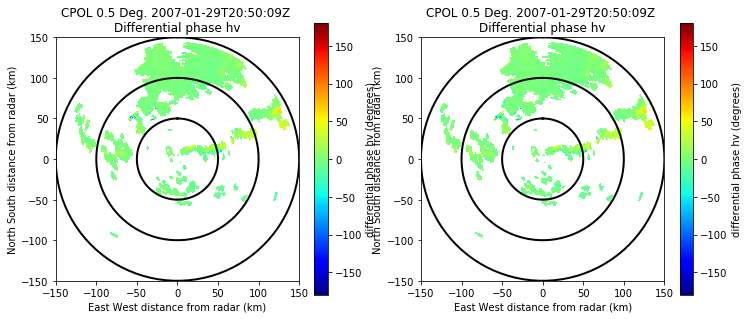

In [29]:
xy = (-150, 150, -150, 150)

fig, the_ax = pl.subplots(1, 2, figsize=(12, 5))
the_ax = the_ax.flatten()

gr.plot_ppi('new_phidp_unfold', gatefilter=gf, sweep=0, ax=the_ax[0], vmin=-180, vmax=180, cmap='jet')
gr.plot_ppi('PHIDP', gatefilter=gf, sweep=0, ax=the_ax[1], vmin=-180, vmax=180, cmap='jet')
# gr.plot_ppi('KDP', sweep=0, ax=the_ax[2], vmin=-5, vmax=5, gatefilter=gf_despeckeld, cmap='jet')
# gr.plot_ppi('KDP_BRINGI', sweep=0, ax=the_ax[3], vmin=-5, vmax=5, gatefilter=gf_despeckeld, cmap='jet')

for ax_sl in the_ax:
    gr.plot_range_rings([50, 100, 150], ax=ax_sl)
    ax_sl.axis('square')
    ax_sl.axis(xy)

# pl.tight_layout()
pl.show()

# Correct Doppler Velocity & Dealiasing

In [30]:
@jit(cache=True)
def refold_vdop(vdop_art, v_nyq_vel, rth_position):
    tmp = vdop_art
    for j in range(len(rth_position)):
        i = rth_position[j]
        if i == 0:
            continue
        else:
            tmp[j, i:] += v_nyq_vel
    
    pos = (vdop_art > v_nyq_vel)
    tmp[pos] = tmp[pos] - 2*v_nyq_vel
    
    return tmp


In [31]:
vdop_art = deepcopy(radar.fields['VEL']['data'])

try:
    v_nyq_vel = radar.instrument_parameters['nyquist_velocity']['data'][0]
except:
    v_nyq_vel = np.max(np.abs(radar.fields['VEL']['data']))    

In [32]:
doppler_refold = False
if pos_unfold is not None:
    vdop_refolded = refold_vdop(vdop_art, v_nyq_vel, pos_unfold)
    radar.add_field_like('VEL', 'vdop_art', vdop_refolded, replace_existing=True)
    doppler_refold = True    

In [33]:
if doppler_refold:
    vdop_vel = pyart.correct.dealias_region_based(radar, vel_field='vdop_art', gatefilter=gf_despeckeld, nyquist_vel=v_nyq_vel)
else:
    vdop_vel = pyart.correct.dealias_region_based(radar, vel_field='VEL', gatefilter=gf_despeckeld, nyquist_vel=v_nyq_vel)

In [34]:
vdop_vel['standard_name'] = radar.fields['VEL']['standard_name']
radar.add_field('vdop_vel', vdop_vel, replace_existing = True)

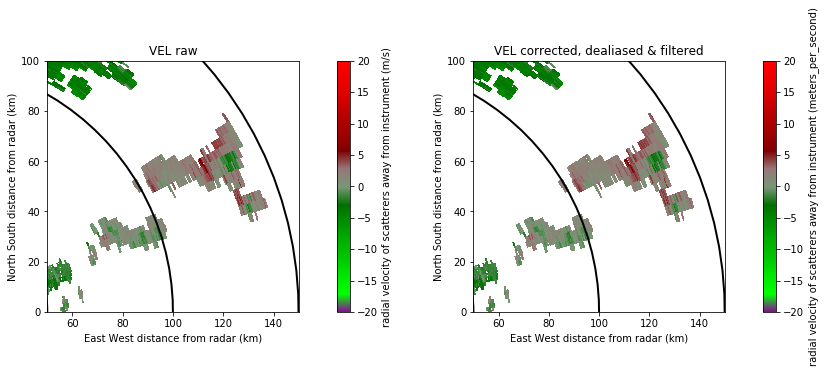

In [35]:
xy = (50, 150, 0, 100)

fig, ((ax0, ax1)) = pl.subplots(1, 2, figsize=(12, 5))
gr.plot_ppi('VEL', ax=ax0, cmap=pyart.graph.cm.NWSVel, gatefilter=gf_despeckeld, vmin=-20, vmax=20)
gr.plot_range_rings([50, 100, 150], ax=ax0)
ax0.axis('square')
ax0.axis(xy)
ax0.set_title('VEL raw')

gr.plot_ppi('vdop_vel', ax=ax1, cmap=pyart.graph.cm.NWSVel, vmin=-20, vmax=20)
gr.plot_range_rings([50, 100, 150], ax=ax1)
ax1.axis('square')
ax1.axis(xy)
ax1.set_title('VEL corrected, dealiased & filtered')

pl.tight_layout()
pl.show()

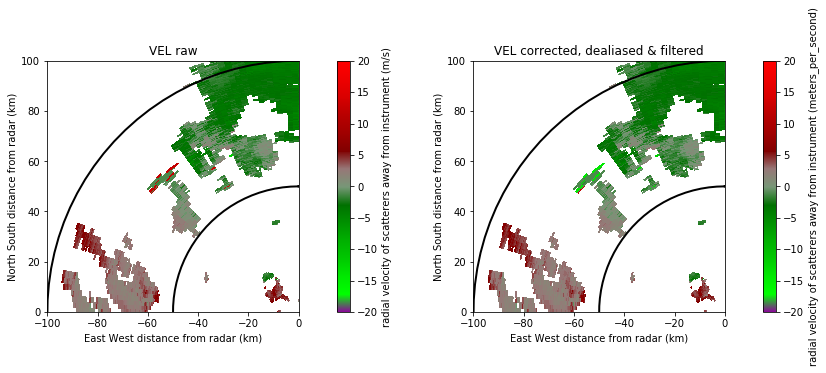

In [36]:
xy = (-100, 0, 0, 100)

fig, ((ax0, ax1)) = pl.subplots(1, 2, figsize=(12, 5))
gr.plot_ppi('VEL', ax=ax0, cmap=pyart.graph.cm.NWSVel, gatefilter=gf_despeckeld, vmin=-20, vmax=20)
gr.plot_range_rings([50, 100, 150], ax=ax0)
ax0.axis('square')
ax0.axis(xy)
ax0.set_title('VEL raw')

gr.plot_ppi('vdop_vel', ax=ax1, cmap=pyart.graph.cm.NWSVel, vmin=-20, vmax=20)
gr.plot_range_rings([50, 100, 150], ax=ax1)
ax1.axis('square')
ax1.axis(xy)
ax1.set_title('VEL corrected, dealiased & filtered')

pl.tight_layout()
pl.show()

# Correct attenuation ZH

In [37]:
def compute_attenuation(kdp, alpha = 0.08, dr = 0.25):
    """
    Note: iflag_loc gives location flag
    c       1: Darwin data  2: SCSMEX data
    c Note: thrcrr is the rhohv threshold
    c       htL/htU are the lower and upper heights
    c       defining the melting layer , in km
    c       alpha is defined by Ah=alpha*Kdp
    c       beta is defined by  Ah-Av=beta*Kdp
    c       The settings below will override the
    c       default values set in plt.f main menu.
    """
    # alpha = 0.08
    # beta = 0.016
    kdp[kdp < 0] = 0
    atten_specific = alpha*kdp
    atten_specific[np.isnan(atten_specific)] = 0
    atten = 2 * np.cumsum(atten_specific, axis=1) * dr
        
    return atten_specific, atten

In [38]:
kdp = radar.fields['KDP']['data']
atten_spec, atten = compute_attenuation(kdp, alpha=0.08, dr=0.3)

/data/vlouf/anaconda3/envs/radar/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in less


In [39]:
radar.add_field_like('DBZ', 'ATTEN_SPEC', atten_spec, replace_existing=True)
radar.add_field_like('DBZ', 'ATTEN', atten, replace_existing=True)

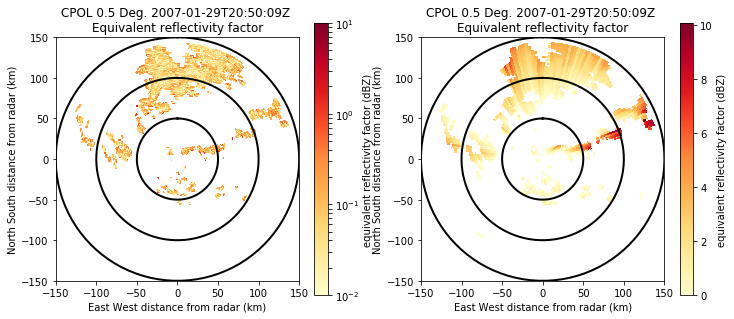

In [40]:
xy = (-150, 150, -150, 150)

fig, the_ax = pl.subplots(1, 2, figsize=(12, 5))
the_ax = the_ax.flatten()

gr.plot_ppi('ATTEN_SPEC', sweep=0, norm=colors.LogNorm(vmin=0.01, vmax=10), ax=the_ax[0], gatefilter=gf_despeckeld, cmap='YlOrRd')
gr.plot_ppi('ATTEN', sweep=0, ax=the_ax[1], gatefilter=gf_despeckeld, cmap='YlOrRd')

for ax_sl in the_ax:
    gr.plot_range_rings([50, 100, 150], ax=ax_sl)
    ax_sl.axis('square')
    ax_sl.axis(xy)

# gr.cbs[-1] = adjust_fhc_colorbar_for_pyart(gr.cbs[-1])
pl.show()

In [41]:
zh = radar.fields['DBZ']['data']
radar.add_field_like('DBZ', 'zcorr', zh + atten, replace_existing=True)

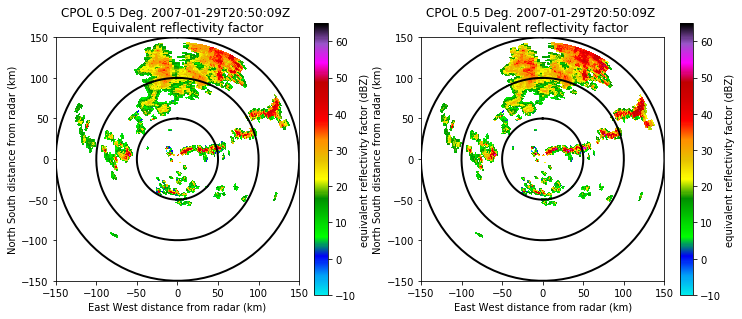

In [42]:
xy = (-150, 150, -150, 150)

fig, the_ax = pl.subplots(1, 2, figsize=(12, 5))
the_ax = the_ax.flatten()

gr.plot_ppi('DBZ', sweep=0, vmin=-10, vmax=65, ax=the_ax[0], gatefilter=gf_despeckeld, cmap=pyart.graph.cm.NWSRef)
gr.plot_ppi('zcorr', sweep=0, vmin=-10, vmax=65, ax=the_ax[1], gatefilter=gf_despeckeld, cmap=pyart.graph.cm.NWSRef)

for ax_sl in the_ax:
    gr.plot_range_rings([50, 100, 150], ax=ax_sl)
    ax_sl.axis('square')
    ax_sl.axis(xy)

# gr.cbs[-1] = adjust_fhc_colorbar_for_pyart(gr.cbs[-1])
pl.show()

# Correct attenuation ZDR

In [43]:
atten_spec, atten = compute_attenuation(kdp, alpha=0.016, dr=0.3)

/data/vlouf/anaconda3/envs/radar/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in less


In [44]:
radar.add_field_like('DBZ', 'AHS_ZDR', atten_spec, replace_existing=True)
radar.add_field_like('DBZ', 'AHI_ZDR', atten, replace_existing=True)

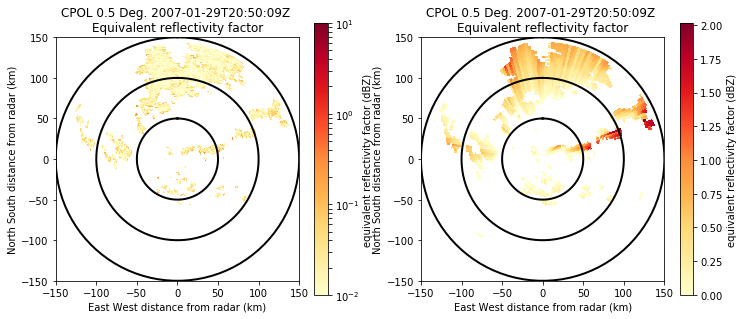

In [45]:
xy = (-150, 150, -150, 150)

fig, the_ax = pl.subplots(1, 2, figsize=(12, 5))
the_ax = the_ax.flatten()

gr.plot_ppi('AHS_ZDR', sweep=0, norm=colors.LogNorm(vmin=0.01, vmax=10), ax=the_ax[0], gatefilter=gf_despeckeld, cmap='YlOrRd')
gr.plot_ppi('AHI_ZDR', sweep=0, ax=the_ax[1], gatefilter=gf_despeckeld, cmap='YlOrRd')

for ax_sl in the_ax:
    gr.plot_range_rings([50, 100, 150], ax=ax_sl)
    ax_sl.axis('square')
    ax_sl.axis(xy)

# gr.cbs[-1] = adjust_fhc_colorbar_for_pyart(gr.cbs[-1])
pl.show()

In [46]:
zdr = radar.fields['ZDR_CORR']['data']
radar.add_field_like('ZDR', 'zdr_corr', zdr + atten, replace_existing=True)

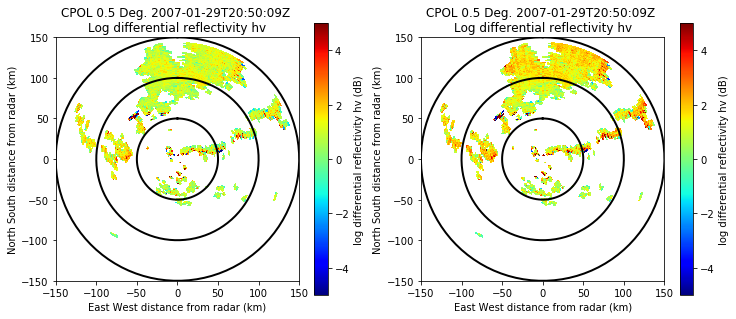

In [47]:
xy = (-150, 150, -150, 150)

fig, the_ax = pl.subplots(1, 2, figsize=(12, 5))
the_ax = the_ax.flatten()

gr.plot_ppi('ZDR', sweep=0, vmin=-5, vmax=5, ax=the_ax[0], gatefilter=gf_despeckeld, cmap='jet')
gr.plot_ppi('zdr_corr', sweep=0, vmin=-5, vmax=5, ax=the_ax[1], gatefilter=gf_despeckeld,cmap='jet')

for ax_sl in the_ax:
    gr.plot_range_rings([50, 100, 150], ax=ax_sl)
    ax_sl.axis('square')
    ax_sl.axis(xy)

# gr.cbs[-1] = adjust_fhc_colorbar_for_pyart(gr.cbs[-1])
pl.show()

# csu_fhc

In [48]:
dz = radar.fields['zcorr']['data']
dr = radar.fields['zdr_corr']['data']
kd = radar.fields['KDP']['data']
rh = radar.fields['RHOHV']['data']
radar_T = radar.fields['sounding_temperature']['data']
radar_z = radar.fields['height']['data']

In [49]:
scores = csu_fhc.csu_fhc_summer(dz=dz, zdr=dr, rho=rh, kdp=kd, use_temp=True, band='C', T=radar_T)
fh = np.argmax(scores, axis=0) + 1

In [50]:
field_name='FH'
fill_value = -32768
masked_field = np.ma.asanyarray(fh)
masked_field.mask = masked_field == fill_value

field_dict = {'data': masked_field,
              'units': 'unitless',
              'long_name': 'Hydrometeor ID',
              'standard_name': 'Hydrometeor ID',
              '_FillValue': -32768}
radar.add_field(field_name, field_dict, replace_existing=True)

In [51]:
from matplotlib import colors

hid_colors = ['White', 'LightBlue', 'MediumBlue', 'DarkOrange', 'LightPink',
              'Cyan', 'DarkGray', 'Lime', 'Yellow', 'Red', 'Fuchsia']
cmaphid = colors.ListedColormap(hid_colors)


In [52]:
def adjust_fhc_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(1.4, 10, 0.9))
    cb.ax.set_yticklabels(['Drizzle', 'Rain', 'Ice Crystals', 'Aggregates',
                           'Wet Snow', 'Vertical Ice', 'LD Graupel',
                           'HD Graupel', 'Hail', 'Big Drops'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

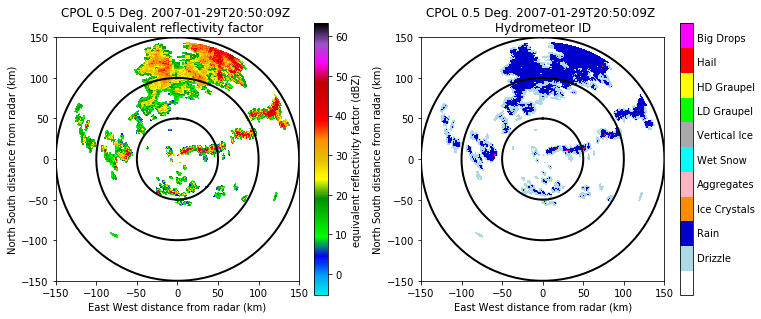

In [53]:
xy = (-150, 150, -150, 150)

fig, the_ax = pl.subplots(1, 2, figsize=(12, 5))
the_ax = the_ax.flatten()

gr.plot_ppi('zcorr', sweep=0, ax=the_ax[0], gatefilter=gf_despeckeld,  cmap=pyart.graph.cm.NWSRef)
gr.plot_ppi('FH', sweep=0, vmin=0, vmax=10, ax=the_ax[1], cmap=cmaphid, gatefilter=gf_despeckeld)

for ax_sl in the_ax:
    gr.plot_range_rings([50, 100, 150], ax=ax_sl)
    ax_sl.axis('square')
    ax_sl.axis(xy)

gr.cbs[-1] = adjust_fhc_colorbar_for_pyart(gr.cbs[-1])
pl.show()


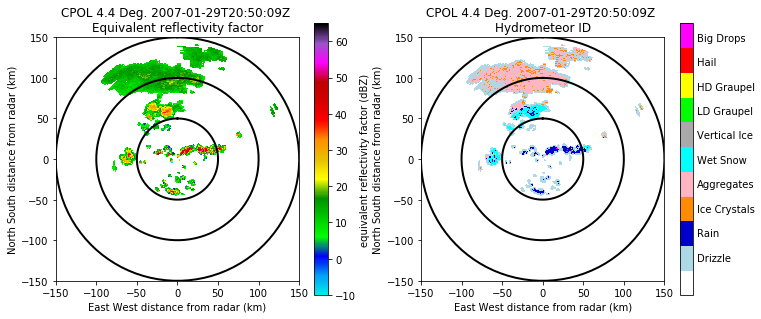

In [54]:
xy = (-150, 150, -150, 150)

fig, the_ax = pl.subplots(1, 2, figsize=(12, 5))
the_ax = the_ax.flatten()

gr.plot_ppi('DBZ', sweep=5, ax=the_ax[0], gatefilter=gf_despeckeld,  cmap=pyart.graph.cm.NWSRef)
gr.plot_ppi('FH', sweep=5, vmin=0, vmax=10, ax=the_ax[1], cmap=cmaphid, gatefilter=gf_despeckeld)

for ax_sl in the_ax:
    gr.plot_range_rings([50, 100, 150], ax=ax_sl)
    ax_sl.axis('square')
    ax_sl.axis(xy)

gr.cbs[-1] = adjust_fhc_colorbar_for_pyart(gr.cbs[-1])
pl.show()

# Liquid/Ice mass

In [55]:
mw, mi = csu_liquid_ice_mass.calc_liquid_ice_mass(dz, dr, radar_z/1000, T=radar_T, method='cifelli')
mw = {'data': mw, 'units': 'g m-3', 'long_name': 'Liquid Water Mass', 'standard_name': 'Liquid Water Mass'}
mi = {'data': mi, 'units': 'g m-3', 'long_name': 'Ice Water Mass', 'standard_name': 'Ice Water Mass'}

radar.add_field('MW', mw, replace_existing=True)
radar.add_field('MI', mi, replace_existing=True)

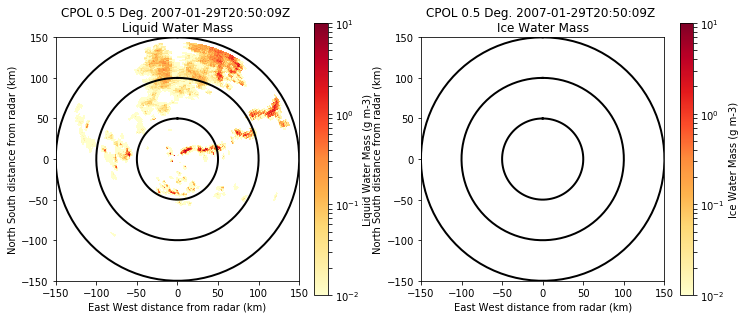

In [56]:
xy = (-150, 150, -150, 150)

fig, the_ax = pl.subplots(1, 2, figsize=(12, 5))
the_ax = the_ax.flatten()

gr.plot_ppi('MW', sweep=0, norm=colors.LogNorm(vmin=0.01, vmax=10), ax=the_ax[0], gatefilter=gf_despeckeld, cmap='YlOrRd')
gr.plot_ppi('MI', sweep=0, norm=colors.LogNorm(vmin=0.01, vmax=10), ax=the_ax[1], gatefilter=gf_despeckeld, cmap='YlOrRd')

for ax_sl in the_ax:
    gr.plot_range_rings([50, 100, 150], ax=ax_sl)
    ax_sl.axis('square')
    ax_sl.axis(xy)

# gr.cbs[-1] = adjust_fhc_colorbar_for_pyart(gr.cbs[-1])
pl.show()

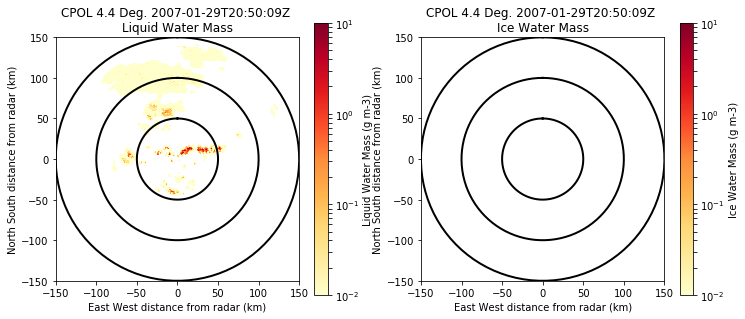

In [57]:
xy = (-150, 150, -150, 150)

fig, the_ax = pl.subplots(1, 2, figsize=(12, 5))
the_ax = the_ax.flatten()

gr.plot_ppi('MW', sweep=5, norm=colors.LogNorm(vmin=0.01, vmax=10), ax=the_ax[0], gatefilter=gf_despeckeld, cmap='YlOrRd')
gr.plot_ppi('MI', sweep=5, norm=colors.LogNorm(vmin=0.01, vmax=10), ax=the_ax[1], gatefilter=gf_despeckeld, cmap='YlOrRd')

for ax_sl in the_ax:
    gr.plot_range_rings([50, 100, 150], ax=ax_sl)
    ax_sl.axis('square')
    ax_sl.axis(xy)

# gr.cbs[-1] = adjust_fhc_colorbar_for_pyart(gr.cbs[-1])
pl.show()